<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn import metrics
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-12-28 01:41:30--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-12-28 01:41:31 (95.0 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



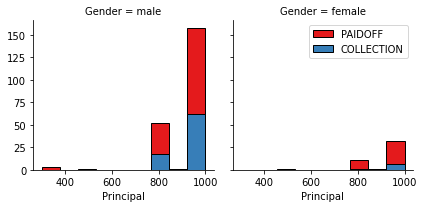

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

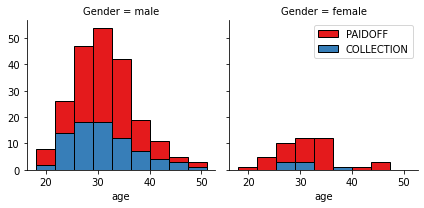

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


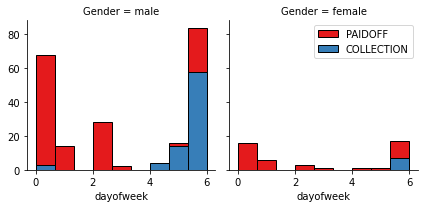

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Convert lables to binary

In [17]:
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Unnamed: 0      346 non-null    int64         
 1   Unnamed: 0.1    346 non-null    int64         
 2   loan_status     346 non-null    int64         
 3   Principal       346 non-null    int64         
 4   terms           346 non-null    int64         
 5   effective_date  346 non-null    datetime64[ns]
 6   due_date        346 non-null    datetime64[ns]
 7   age             346 non-null    int64         
 8   education       346 non-null    object        
 9   Gender          346 non-null    int64         
 10  dayofweek       346 non-null    int64         
 11  weekend         346 non-null    int64         
dtypes: datetime64[ns](2), int64(9), object(1)
memory usage: 32.6+ KB


### Feature Selection


Let's define feature sets, X:


In [19]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [20]:
y = df['loan_status'].values
y[0:5]

array([0, 0, 0, 0, 0])

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [21]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [23]:
from sklearn.neighbors import KNeighborsClassifier

### Initial test of KNN

In [24]:
k = 4
#Train Model and Predict  
knn_clf = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
knn_clf

KNeighborsClassifier(n_neighbors=4)

In [25]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, knn_clf.predict(X_train)))
print("Train set F1 score: ", metrics.f1_score(y_train, knn_clf.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, knn_clf.predict(X_test)))
print("Test set F1 score: ", metrics.f1_score(y_test, knn_clf.predict(X_test)))

Train set Accuracy:  0.8115942028985508
Train set F1 score:  0.5
Test set Accuracy:  0.7714285714285715
Test set F1 score:  0.2


#### As seen above, considerably high accuracy and low F1 score indicates imbalance in the target class distribution.

### Let's test the F1-score of k-means for different values of k

In [26]:
Ks = 40
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    # Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat_knn_test = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat_knn_test)

    
    std_acc[n-1]=np.std(yhat_knn_test==y_test)/np.sqrt(yhat_knn_test.shape[0])

mean_acc

array([0.67142857, 0.77142857, 0.71428571, 0.77142857, 0.75714286,
       0.78571429, 0.78571429, 0.77142857, 0.75714286, 0.75714286,
       0.7       , 0.68571429, 0.7       , 0.68571429, 0.68571429,
       0.7       , 0.72857143, 0.71428571, 0.7       , 0.71428571,
       0.71428571, 0.71428571, 0.7       , 0.74285714, 0.72857143,
       0.81428571, 0.77142857, 0.8       , 0.78571429, 0.78571429,
       0.78571429, 0.78571429, 0.78571429, 0.8       , 0.78571429,
       0.78571429, 0.78571429, 0.78571429, 0.78571429])

### Plot model accuracy for different numbers of neighbors k

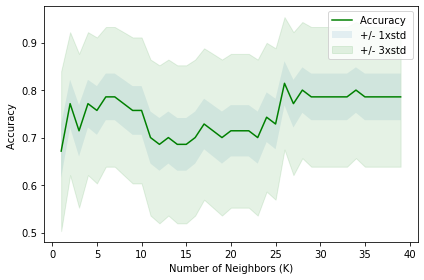

In [27]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [28]:
print( "The best Accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best Accuracy was with 0.8142857142857143 with k= 26


In [29]:
knn_clf = KNeighborsClassifier(n_neighbors = mean_acc.argmax()+1).fit(X_train,y_train)
knn_clf

KNeighborsClassifier(n_neighbors=26)

In [30]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, knn_clf.predict(X_train)))
print("Train set F1 score: ", metrics.f1_score(y_train, knn_clf.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, knn_clf.predict(X_test)))
print("Test set F1 score: ", metrics.f1_score(y_test, knn_clf.predict(X_test)))

Train set Accuracy:  0.7536231884057971
Train set F1 score:  0.17073170731707318
Test set Accuracy:  0.8142857142857143
Test set F1 score:  0.23529411764705882


# Decision Tree


In [31]:
from sklearn.tree import DecisionTreeClassifier

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [33]:
dt_clf = DecisionTreeClassifier()  # criterion="entropy", max_depth = 4)
dt_clf.fit(X_train, y_train)
dt_clf

DecisionTreeClassifier()

In [34]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, dt_clf.predict(X_train)))
print("Train set F1 score: ", metrics.f1_score(y_train, dt_clf.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, dt_clf.predict(X_test)))
print("Test set F1 score: ", metrics.f1_score(y_test, dt_clf.predict(X_test)))

Train set Accuracy:  0.9094202898550725
Train set F1 score:  0.806201550387597
Test set Accuracy:  0.7285714285714285
Test set F1 score:  0.38709677419354843


# Support Vector Machine


In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [36]:
from sklearn import svm
svm_clf = svm.SVC(kernel='rbf')
svm_clf.fit(X_train, y_train) 

SVC()

In [37]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, svm_clf.predict(X_train)))
print("Train set F1 score: ", metrics.f1_score(y_train, svm_clf.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, svm_clf.predict(X_test)))
print("Test set F1 score: ", metrics.f1_score(y_test, svm_clf.predict(X_test)))

Train set Accuracy:  0.782608695652174
Train set F1 score:  0.4999999999999999
Test set Accuracy:  0.7428571428571429
Test set F1 score:  0.30769230769230765


### Let's test SVC with different hyper-parameters, optimizing F1-score during the search

In [38]:
best_f1 = 0.0
for C in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]:
    svm_clf_test = svm.SVC(kernel='rbf', C=C).fit(X_train, y_train)
    y_hat_test = svm_clf_test.predict(X_test)
    f1 = metrics.f1_score(y_test, y_hat_test, average='weighted')
    if f1 > best_f1:
        best_f1 = f1
        svm_clf = svm_clf_test
        print('Improved SVC model with C = ', C, '; f1-score = ', f1)
svm_clf

Improved SVC model with C =  1e-05 ; f1-score =  0.6914285714285714
Improved SVC model with C =  1 ; f1-score =  0.7275882012724117
Improved SVC model with C =  1000 ; f1-score =  0.7331564204629221


SVC(C=1000)

In [39]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, svm_clf.predict(X_train)))
print("Train set F1 score: ", metrics.f1_score(y_train, svm_clf.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, svm_clf.predict(X_test)))
print("Test set F1 score: ", metrics.f1_score(y_test, svm_clf.predict(X_test)))

Train set Accuracy:  0.8442028985507246
Train set F1 score:  0.6766917293233083
Test set Accuracy:  0.7142857142857143
Test set F1 score:  0.47368421052631576


# Logistic Regression


In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
lr_clf = LogisticRegression().fit(X_train,y_train)
lr_clf

LogisticRegression()

In [42]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, lr_clf.predict(X_train)))
print("Train set F1 score: ", metrics.f1_score(y_train, lr_clf.predict(X_train)))
print("Train set logloss: ", metrics.log_loss(y_train, lr_clf.predict_proba(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, lr_clf.predict(X_test)))
print("Test set F1 score: ", metrics.f1_score(y_test, lr_clf.predict(X_test)))
print("Test set logloss: ", metrics.log_loss(y_test, lr_clf.predict_proba(X_test)))

Train set Accuracy:  0.7717391304347826
Train set F1 score:  0.4324324324324324
Train set logloss:  0.4210803625154324
Test set Accuracy:  0.7285714285714285
Test set F1 score:  0.1739130434782609
Test set logloss:  0.5001817646359401


# Model Evaluation using Test set


In [43]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [44]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-12-28 01:41:42--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-12-28 01:41:43 (42.8 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [45]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


## Pre-processing of test data

In [46]:
def preprocess(df):
    ### Convert to date time object
    df['due_date'] = pd.to_datetime(df['due_date'])
    df['effective_date'] = pd.to_datetime(df['effective_date'])
    # Pre-processing:  Feature selection/extraction
    df['dayofweek'] = df['effective_date'].dt.dayofweek
    df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
    ## Convert Categorical features to numerical values
    df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
    # Convert labels to binary
    df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
    print('df dataframe:\n', df.head())
    ## One Hot Encoding
    #### How about education?
    #### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame
    Feature = df[['Principal','terms','age','Gender','weekend']]
    Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
    Feature.drop(['Master or Above'], axis = 1,inplace=True)
    # Feature selection
    X = Feature
    print('X dataframe:\n', X.head())
    y = df['loan_status'].values
    ## Normalize Data
    X = preprocessing.StandardScaler().fit(X).transform(X)
    return X, y

In [47]:
X_test, y_test = preprocess(test_df.copy())

df dataframe:
    Unnamed: 0  Unnamed: 0.1  loan_status  Principal  terms effective_date  \
0           1             1            0       1000     30     2016-09-08   
1           5             5            0        300      7     2016-09-09   
2          21            21            0       1000     30     2016-09-10   
3          24            24            0       1000     30     2016-09-10   
4          35            35            0        800     15     2016-09-11   

    due_date  age             education  Gender  dayofweek  weekend  
0 2016-10-07   50              Bechalor       1          3        0  
1 2016-09-15   35       Master or Above       0          4        1  
2 2016-10-09   43  High School or Below       1          5        1  
3 2016-10-09   26               college       0          5        1  
4 2016-09-25   29              Bechalor       0          6        1  
X dataframe:
    Principal  terms  age  Gender  weekend  Bechalor  High School or Below  \
0       100

In [48]:
yhat_dict = dict()
yhat_dict['KNN'] = knn_clf.predict(X_test)
yhat_dict['Decision Tree'] = dt_clf.predict(X_test)
yhat_dict['SVM'] = svm_clf.predict(X_test)
yhat_dict['LogisticRegression'] = lr_clf.predict(X_test)
#yhat_dict['svm_linear'] = svm_clf_linear.predict(X_test)

## Calculating evaluation metrics

In [49]:
metrics_list = []
for clf_name, yhat in yhat_dict.items():
    accuracy = np.round(metrics.accuracy_score(y_test, yhat), 2)
    jaccard = np.round(metrics.jaccard_score(y_test, yhat, pos_label=0), 2)
    f1 = np.round(f1_score(y_test, yhat, average='weighted'), 2)
    if clf_name == 'LogisticRegression':
        # **predict_proba**  returns estimates for all classes, ordered by the label of classes.
        yhat_prob = lr_clf.predict_proba(X_test)
        logloss = np.round(log_loss(y_test, yhat_prob), 2)
    else:
        logloss = np.nan
    metrics_list.append((clf_name, jaccard, f1, logloss))
# end for
metrics_list

[('KNN', 0.75, 0.71, nan),
 ('Decision Tree', 0.65, 0.69, nan),
 ('SVM', 0.67, 0.7, nan),
 ('LogisticRegression', 0.74, 0.66, 0.47)]

### jaccard index

We can define jaccard as the size of the intersection divided by the size of the union of the two label sets. If the entire set of predicted labels for a sample strictly matches with the true set of labels, then the subset accuracy is 1.0; otherwise it is 0.0.

### F1 score

The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. It is a good way to show that a classifer has a good value for both recall and precision.

### log loss

Log loss( Logarithmic loss) measures the performance of a classifier where the predicted output is a probability value between 0 and 1.

In [50]:
metrics_df = pd.DataFrame.from_records(metrics_list, columns=['Algorithm', 'Jaccard', 'F1-score', 'LogLoss']).set_index(['Algorithm'])
metrics_df

,Jaccard,F1-score,LogLoss
Algorithm,,,
KNN,0.75,0.71,NaN
Decision Tree,0.65,0.69,NaN
SVM,0.67,0.70,NaN
LogisticRegression,0.74,0.66,0.47


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
